# Comparaison of two policies

In this notebook, we give the possibilty to compare two policies

Given two trained policies, for each policy we will simulate a certain number of rounds against a random policy, and we check if one is significantly better than the other

## Imports

In [1]:
import statsmodels
import pandas as pd
import numpy as np
import scipy.stats as scs
import sys
sys.path.append("../")
import matplotlib.pyplot as plt

from generate_rounds_with_policies import policy_competition
from utils_policy_comparaison import size_sample_AB_test, test_H0, power_test, confidence_interval_diff

/anaconda/envs/gym-coinche/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda/envs/gym-coinche/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda/envs/gym-coinche/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda/envs/gym-coinche/lib/python3.7/site-packages/tensorflow/pyth

['.ipynb_checkpoints', '__pycache__', 'AB_testing.ipynb', 'data', 'games_and_rewards.ipynb', 'policy_comparaison.ipynb', 'random_games_and_rewards_analysis.ipynb', 'README', 'reward_model.h5', 'train_reward_prediction_model.py', 'utils_policy_comparaison.py']


/anaconda/envs/gym-coinche/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda/envs/gym-coinche/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda/envs/gym-coinche/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda/envs/gym-coinche/lib/python3.7/site-pac

In [2]:
NUM_EPISODES = 1000
policy_algo = ["Random",
               "Random",
               "Random",
               "Random"]

contrat_model_path = None


random_data, random_attack = policy_competition(policies=policy_algo, 
                                                env_name = "coinche-v3",
                                                contrat_model_path=contrat_model_path, 
                                                NUM_EPISODES=NUM_EPISODES)

Contrat model passed:  None
Contrat model passed:  None
0
500
Done


In [3]:
random_data.head()

,atout_7_p1,atout_8_p1,atout_9_p1,atout_10_p1,atout_jack_p1,atout_queen_p1,atout_king_p1,atout_as_p1,na1_7_p1,na1_8_p1,...,na2_as_p4,na3_7_p4,na3_8_p4,na3_9_p4,na3_10_p4,na3_jack_p4,na3_queen_p4,na3_king_p4,na3_as_p4,total_reward
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,90.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,33.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,124.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,54.0


## Sizing the test

In a first approach, we are making an A/B test. So we need to to have an estimation of the size of the samples that will be needed

count    1000.000000
mean       82.093000
std        34.601555
min         0.000000
25%        56.000000
50%        83.000000
75%       108.250000
max       162.000000
Name: total_reward, dtype: float64


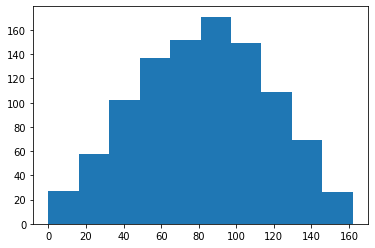

In [4]:
plt.hist(random_data["total_reward"])
print(random_data["total_reward"].describe())

In [2]:
# We want to be able to detect one point of difference of total reward for the attack, and one point for defense
mde = 1
risk1 = 0.05
risk2 = 0.2

# under a random policy, the distribution is centered in 82 with std of 35
std = 35

In [3]:
size_sample_AB_test(risk1, risk2, var = std**2, mde = mde, bilateral=True)

19229.755349155268

We will make the assumption that std is not really moving even with better policies.
Moreover, we'll take a bit bigger samples to be sure (as it doesn't cost anything to do so)

## Comparing policies

TOTAL_REWARD is the total reward for the team in which there is the GymPlayer. Usually, it is set for team 0 (player 0 and player 2)

In [10]:
# Given the A/B test sizing performed above, we need 20000 rounds for attacks and 
# 20000 for defense. As the reward model is called on random games, attacks and defens
# will be 50%-50%

NUM_EPISODES = 25000

# If we want to save the data after
save = True

#Policy_algo is a list. Each value of the list is the policy of player i
policy_algo = ["../experiments/coinche/15_05_2020-11_27/checkpoint/4_Step-13212.ckpt",
               "Random",
               '../experiments/coinche/15_05_2020-11_27/checkpoint/4_Step-13212.ckpt',
               "Random"]

# contrat_model_path is none if we want to set the contrat given the games quality
contrat_model_path = "../reward_prediction/reward_model.h5"
# contrat_model_path = None

competition_data, competition_attack = policy_competition(policies=policy_algo, 
                                                          env_name = "coinche-v3",
                                                          contrat_model_path=contrat_model_path, 
                                                          NUM_EPISODES=NUM_EPISODES)

if save:
    competition_data.to_csv("./data/competition_against_random.csv")
    competition_attack.to_csv("./data/attacks_against_random.csv")
    
    competition_data = pd.read_csv("./data/competition_against_random.csv")
    competition_attack = pd.read_csv("./data/attacks_against_random.csv")

Contrat model passed:  None
Contrat model passed:  None
INFO:tensorflow:Restoring parameters from ../experiments/coinche/15_05_2020-11_27/checkpoint/4_Step-13212.ckpt
INFO:tensorflow:Restoring parameters from ../experiments/coinche/15_05_2020-11_27/checkpoint/4_Step-13212.ckpt
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
Done


In [11]:
competition_data = competition_data.merge(competition_attack,
                                          right_index = True,
                                          left_index = True)

competition_data['total_reward_team_02'] = competition_data['total_reward']
competition_data['total_reward_team_13'] = 162-competition_data['total_reward']

# Check repartition of attack vs defens
competition_data['p0'].value_counts()

1    12602
0    12398
Name: p0, dtype: int64

Let's set the attack and defens datasets

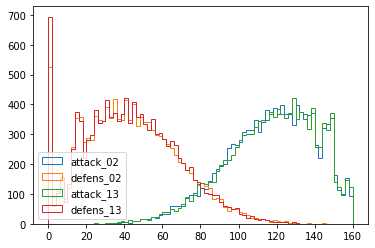

In [12]:
attack_02 = competition_data[competition_data['p0']==1]['total_reward_team_02']
defens_02 = competition_data[competition_data['p0']==0]['total_reward_team_02']
attack_13 = competition_data[competition_data['p1']==1]['total_reward_team_13']
defens_13 = competition_data[competition_data['p1']==0]['total_reward_team_13']

kwargs = dict(histtype='step', 
              bins=np.arange(0, 162, 2))

plt.hist(attack_02,  label = "attack_02", **kwargs)
plt.hist(defens_02, label = "defens_02",  **kwargs)
plt.hist(attack_13,  label = "attack_13", **kwargs)
plt.hist(defens_13, label = "defens_13",  **kwargs)
plt.legend(loc=3)
plt.show()


In [13]:
defens_02.describe(), defens_13.describe()

(count    12398.000000
 mean        43.315535
 std         25.032755
 min          0.000000
 25%         25.000000
 50%         41.000000
 75%         60.000000
 max        148.000000
 Name: total_reward_team_02, dtype: float64,
 count    12602.000000
 mean        42.865180
 std         25.010478
 min          0.000000
 25%         24.000000
 50%         41.000000
 75%         60.000000
 max        149.000000
 Name: total_reward_team_13, dtype: float64)

In [14]:
attack_02.describe(), attack_13.describe()

(count    12602.000000
 mean       119.134820
 std         25.010478
 min         13.000000
 25%        102.000000
 50%        121.000000
 75%        138.000000
 max        162.000000
 Name: total_reward_team_02, dtype: float64,
 count    12398.000000
 mean       118.684465
 std         25.032755
 min         14.000000
 25%        102.000000
 50%        121.000000
 75%        137.000000
 max        162.000000
 Name: total_reward_team_13, dtype: float64)

#### Let's perform the tests

In [15]:
# Attack
test_attack = test_H0(attack_02, attack_13, risk1, bilateral=True)
test_defens = test_H0(defens_02, defens_13, risk1, bilateral=True)

for test in [test_attack, test_defens]:
    
    if test[0]:
        print("No significative difference of means")
        print("power: ", np.round(100*power_test(attack_02, attack_13, mde, risk1, bilateral=True),1), "%")
    else:
        print("signiticative difference:")
        print()
        intervale = confidence_interval_diff(attack_13, attack_02)
        if intervale[0] > 0:
            
            print("Mamia is better than random !!!!")
            print(np.round(intervale[0], 2), "  <---->  ", np.round(intervale[1], 2))


        else: 
            print("Damnit, random is better. Let's try again")
            print(np.round(intervale[0], 2), "  <---->  ", np.round(intervale[1], 2))
    print()


No significative difference of means
power:  88.5 %

No significative difference of means
power:  88.5 %



If test_H0 returns True, then, we can accept H0, that is to say that the tested distribution have the same MEAN.
In that case, we check the power of the test. It should be greated than risk2 = 80%

If test_H0 is False, please check the value of the confidence of intervale to check the value of the difference of the means between the two distribution